In [1]:
import os
import sys
import xarray as xr
import dask
import matplotlib.pyplot as plt
import numpy as np
import cmocean.cm as ocm

proj_dir = os.path.join(os.pardir,os.pardir)
data_dir = os.path.join(proj_dir,'data','preprocessing')

out_path = os.path.join(proj_dir,'reports','figures','topography.png')

In [2]:
import os
import sys
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cmocean.cm as ocm

proj_dir = os.path.join(os.pardir,os.pardir)
data_dir = os.path.join(proj_dir,'data','analysis')
int_dir = os.path.join(data_dir,'interim')
raw_dir = os.path.join(data_dir,'raw')
ext_dir = os.path.join(data_dir,'external')
fig_dir = os.path.join(proj_dir,'reports','devel','figures')

src_dir = os.path.join(proj_dir,'src')
sys.path.append(src_dir)

%load_ext autoreload
%autoreload 2
%aimport tools.make_masks

from tools.log_progress import log_progress
from tools.make_masks import make_mask_sector,make_mask_shelf_sector,make_mask_ice_shelves
from visualization.plot_map import get_vrange

In [3]:
#load grid
grd_path = os.path.join(int_dir,'grd2_dV.nc')
grd = xr.open_dataset(grd_path)

sec_mask = make_mask_sector(grd)

grd.mask_rho[1000:1500,2000:2500] = False

mask_sector = make_mask_sector(grd)
mask_shelf = make_mask_shelf_sector(grd,mask_sector,1600) 
mask_shelf['Total Antarctica'][:,3000:]=False
mask_shelf['Total Antarctica'][2500:,:]=False

shelves_masks_path = os.path.join(int_dir,'shelves2.npy') 
shelves = np.load(shelves_masks_path,allow_pickle=True).item()
shelves = {k: v for k, v in shelves.items() if v['mask'].any()}

In [4]:
def plot_map(da,title,cbar_label,cmap,vrange=None,cb_ext='both',ls='xx-large',grd=grd,
             sb=False,secb=False,trans=False,save=False):
        
    vmin,vmax = get_vrange(da,vrange)
    
    plt.close()
    fig,ax = plt.subplots(figsize=(9,11))
    ax.axis('off')
    ax.set_aspect('equal')
    ax.contourf(grd.mask_rho.where(grd.mask_rho==0),colors=(('0.6','0.6','0.6')))   
    cp = da.plot(ax=ax,vmin=vmin,vmax=vmax,cmap=cmap,add_colorbar=False)
    
    
    if sb:
        for key,data in log_progress(shelves.items(),name='shelves'):
               ax.contour(xr.DataArray(data['mask'],dims=('eta_rho','xi_rho')),
                          colors=('black'),linewidths=0.1)
    if secb:            
        for k,sec_mask in mask_sector.items():
            sec_mask.where((grd.mask_rho ==1)&(grd.zice==0.0)).plot.contour(colors=('white'),
                                                                                      linewidths=0.2,ax=ax)
            
    if trans:
        for lon,lat_min,lat_max in trans:
            mask = (grd.mask_rho == 1) & (grd.lat_rho>=lat_min) & (grd.lat_rho<=lat_max)
            ax.contour(grd.lon_rho.where(mask),levels=[[lon]],colors=('white'),linewidths=1,
                  linestyles='dotted')
            
    ax.contour(grd.zice.where(grd.mask_rho==1), levels=['-0.1'], colors=('black'),linewidths=0.1)
    ax.contour(grd.h.where((mask_shelf['Total Antarctica'] == 1) & (grd.zice == 0)), levels=['1500'], colors=('black'),linewidths=0.3)
    ax.contour(grd.mask_rho, colors=('black'),linewidths=0.1)
    
    lons= np.arange(-170,170,10)
    mask_lons = (grd.lon_rho < 176) & (grd.lon_rho > -176) & (grd.mask_rho == 1)
    
    lons = ax.contour(grd.lon_rho.where(mask_lons),levels=lons,colors='white',linewidths=0.2)
    ax.contour(grd.lon_rho.where(grd.mask_rho),levels=[-179.9],colors='white',linewidths=0.2)
    ax.contour(grd.lat_rho.where(grd.mask_rho),levels=np.arange(-90,-50,5),colors='white',linewidths=0.2)
    
    cb = plt.colorbar(cp, ax=ax, orientation="horizontal", pad=0.01, extend=cb_ext)
    cb.set_label(label=cbar_label, size=ls, weight='bold')
    cb.ax.tick_params(labelsize=ls)    
    ax.set_title(title,fontsize=16)
    plt.tight_layout()
    if save==True:
        plt.savefig(os.path.join(fig_dir,'map_'+title.replace('/','_')+'.png'),format='png',bbox_inches = "tight")
    elif save=='hr':
        plt.savefig(os.path.join(fig_dir,'map_'+title.replace('/','_')+'.png'),format='png',dpi=400,bbox_inches = "tight")
    plt.show()
    

<IPython.core.display.Javascript object>


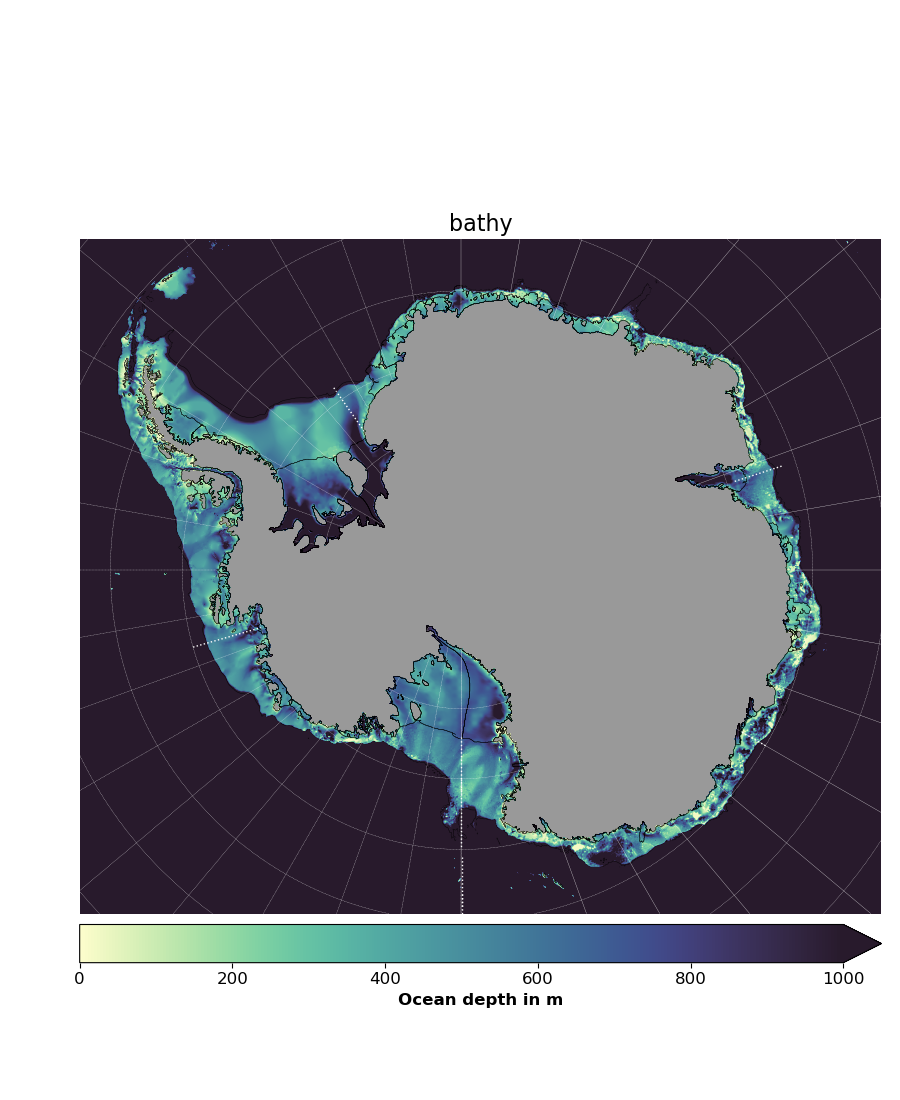

In [10]:
mask = (grd.mask_rho == 1)
#trans = [[-45,-80,-55],[180,-89,-66],[-75,-70,-62],[70,-70,-59]]
trans = [[120,-66.9,-65],[-106,-75,-70],[72,-69.5,-66],[-35,-78,-74]]
plot_map((grd.h).where(mask),'bathy','Ocean depth in m',ocm.deep,[0,1000],cb_ext='max',
         ls ='large',save='hr',trans=trans,sb=True,secb=False)

In [20]:
1-grd.mask_rho.sum()/np.ones_like(grd.mask_rho).sum()

<xarray.DataArray 'mask_rho' ()>
array(0.362663)

In [22]:
grd.dz.isel(s_rho=30).where((grd.zice<0) & (grd.mask_rho==1))

<xarray.DataArray (eta_rho: 2650, xi_rho: 3150)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Dimensions without coordinates: eta_rho, xi_rho

<IPython.core.display.Javascript object>


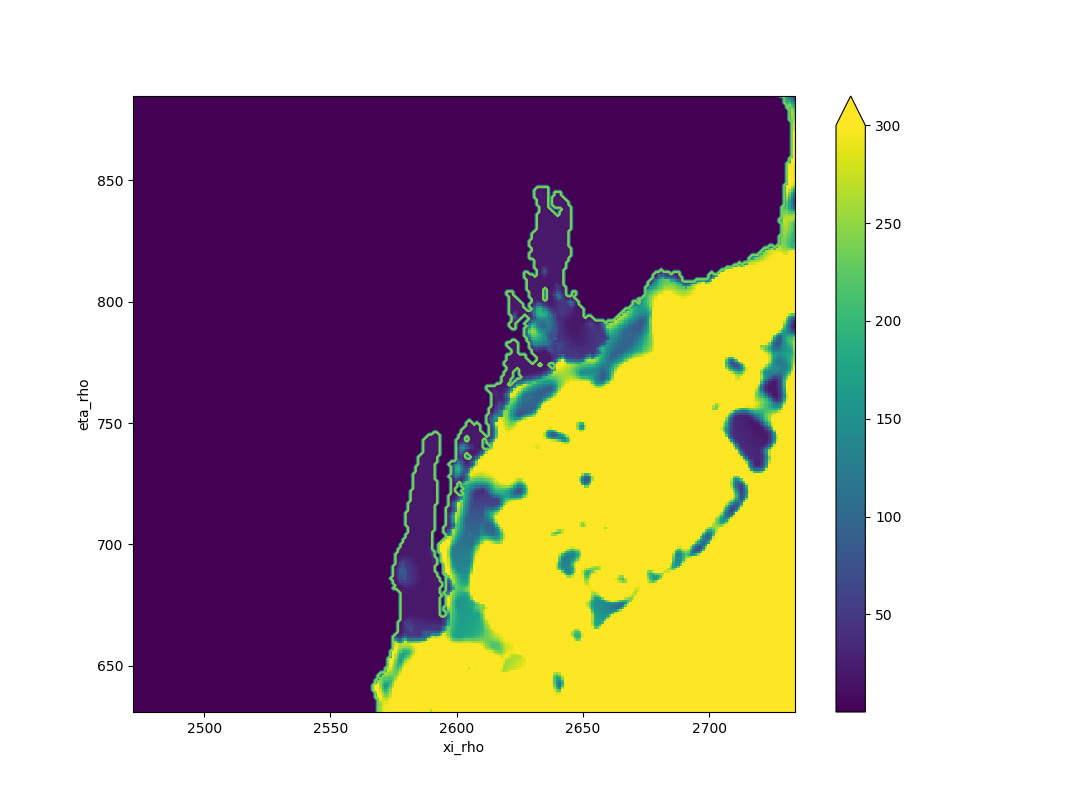

In [7]:
%matplotlib notebook
plt.close()
(grd.h+grd.zice).plot(size=8,vmax = 300)
grd.mask_rho.plot.contour()
plt.show()

In [56]:
mask_ant = np.zeros_like(grd.mask_rho.values)

for k,v in shelves.items():
    mask_ant[v['mask']]=1
    
mask = (mask_ant == 0) & (grd.zice<0) & (grd.mask_rho == 1)
mask.any()

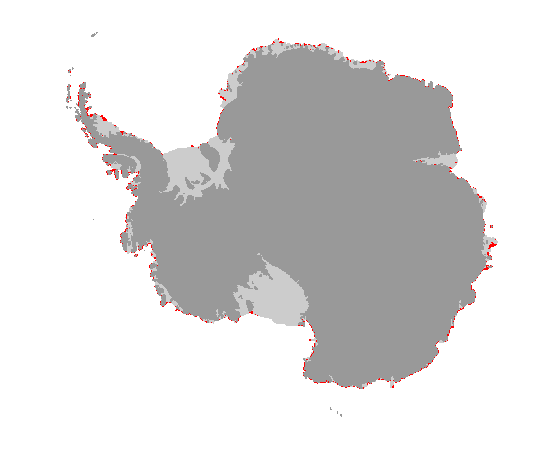

In [65]:
title = 'antbounds_bedmap'
plt.close()
fig,ax = plt.subplots(figsize=(9,11))
ax.axis('off')
ax.set_aspect('equal')

ax.contourf(grd.mask_rho.where(grd.zice<0),colors=(('0.8','0.8','0.8')))

ax.contourf(grd.mask_rho.where(mask),colors='red')
ax.contourf(grd.mask_rho.where(grd.mask_rho==0),colors=(('0.6','0.6','0.6')))
plt.savefig(os.path.join(fig_dir,'map_'+title.replace('/','_')+'.png'),format='png',dpi=300,bbox_inches = "tight")
plt.show()

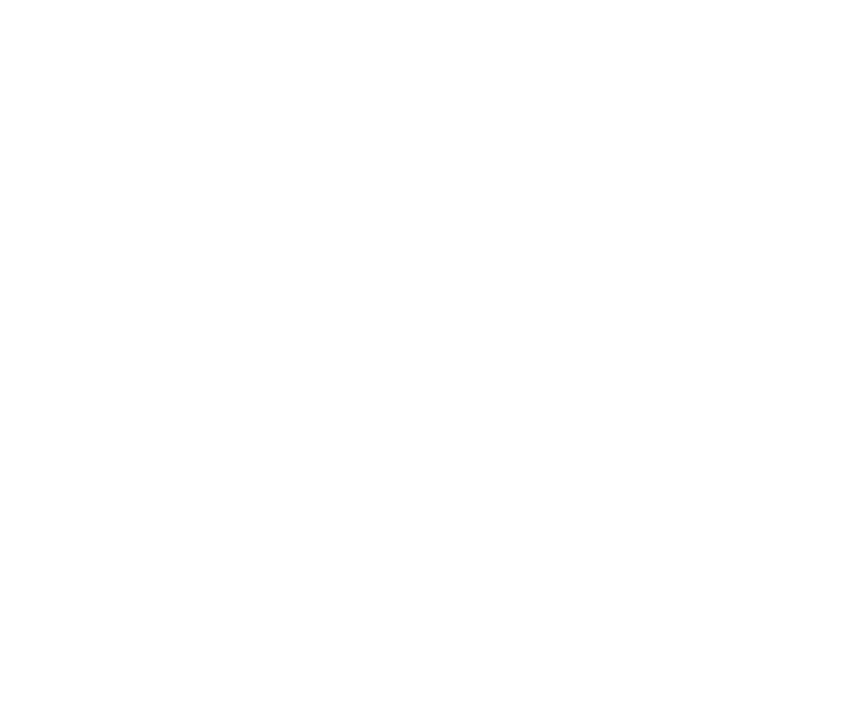

In [34]:
plt.close()
fig,ax = plt.subplots(figsize = (15,10))
img = grd.mask_rho.where(mask).plot(ax=ax,add_colorbar=False)
ax.set_aspect('equal')
ax.axis('off')
plt.tight_layout()
#plt.savefig(os.path.join(fig_dir,'size_mask.png'),transparent=True,dpi=300)
plt.show()

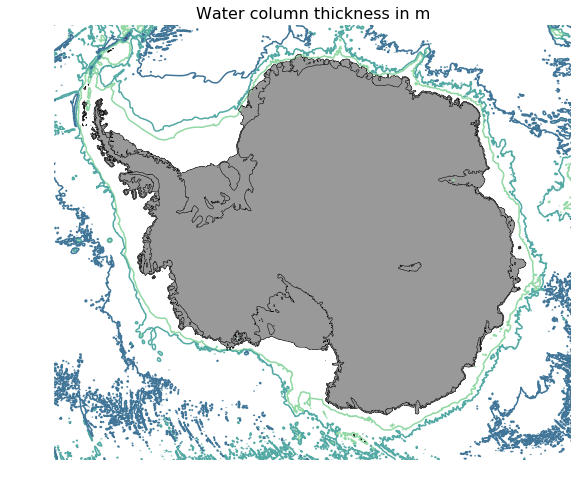

In [4]:
%matplotlib inline
land_zice = (grd.mask_rho==0) | (grd.zice < 0.0)


plt.close()
fig,ax = plt.subplots(figsize=(10,8))
ax.contourf(grd.mask_rho.where(land_zice).values,colors=(('0.6','0.6','0.6')))

(grd.h+grd.zice).where(grd.mask_rho).plot.contour(cmap=ocm.deep,ax=ax)

ax.contour(-grd.zice.where(grd.mask_rho).values, levels=['0.01'], colors=('black'),linewidths=0.5)
ax.contour(grd.mask_rho.values, levels=['0.01'], colors=('black'),linewidths=0.5)
plt.title('Water column thickness in m', fontsize=16)
ax.set_aspect('equal')
ax.axis('off')
plt.savefig(out_path,format='png',dpi=300)
plt.show()

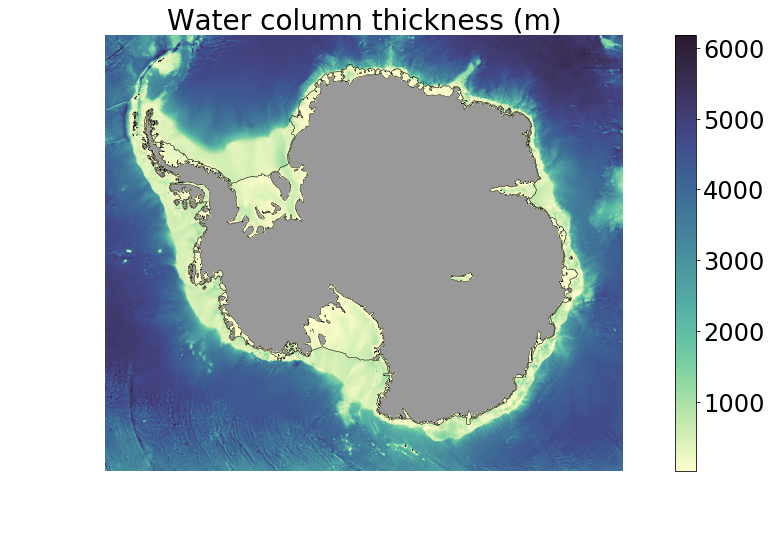

In [23]:
import matplotlib

plt.close()
fig,ax = plt.subplots(figsize=(15,8))
ax.contourf(grd.mask_rho.values,colors=(('0.6','0.6','0.6')))
(grd.h+grd.zice).where(grd.mask_rho).plot(cmap=ocm.deep,cbar_kwargs={'label':''})
ax.contour(-grd.zice.where(grd.mask_rho).values, levels=['0.01'], colors=('black'),linewidths=0.5)
ax.contour(grd.mask_rho.values, levels=['0.01'], colors=('black'),linewidths=0.5)
matplotlib.rcParams.update({'font.size': 24}) 
plt.title('Water column thickness (m)', fontsize=28)
ax.set_aspect('equal')
ax.axis('off')
plt.tight_layout()

if out_path:
    plt.savefig(out_path,format='png',dpi=375)
plt.show()